In [ ]:
import math
import torch
from torch import nn

# Model

In [ ]:
class Swish(nn.Module):
  def forward(self, x):
    return x * torch.sigmoid(x)

In [ ]:
class FeatureEx1d(nn.Module):
  def __init__(self, input_size):
    super().__init__()
    self.layers = nn.Sequential(
        nn.linear(input_size, 256),
        nn.functional.relu(),
        nn.linear(256, 128),
        nn.functional.relu(),
        nn.linear(128, 64),
        nn.functional.relu()
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
class SEblock(nn.Module):
  def __init__(self, ch_in, ch_sq):
    super().__init__()
    self.se = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(ch_in, ch_sq, 1),
        Swish(),
        nn.Conv2d(ch_sq, ch_in, 1),
    )
    self.se.apply(weight_init)

  def forward(self, x):
    return x * torch.sigmoid(self.se(x))

def weight_init(m):
  if isinstance(m, nn.Conv2d):
    nn.init.kaiming_normal_(m.weight)

  if isinstance(m, nn.Linear):
    nn.init.kaiming_uniform_(m.weight)
    nn.init.zeros_(m.bias)

In [ ]:
class ConvBN(nn.Module):
  def __init__(self, ch_in, ch_out, kernel_size, stride=1, padding=0, groups=1):
    super().__init__()
    self.layers=nn.Sequential(
        nn.Conv2d(ch_in, ch_out, kernel_size, stride, padding, groups=groups, bias=False),
        nn.BatchNorm2d(ch_out),
    )
    self.layers.apply(weight_init)

  def forward(self, x):
    return self.layers(x)

In [ ]:
class DropConnect(nn.Module):
  def __init__(self, drop_rate):
    super().__init__()
    self.drop_rate=drop_rate

  def forward(self, x):
    if self.training:
      keep_rate=1.0-self.drop_rate
      r = torch.rand([x.size(0),1,1,1], dtype=x.dtype).to(x.device)
      r+=keep_rate
      mask=r.floor()
      return x.div(keep_rate)*mask
    else:
      return x

In [ ]:
class BMConvBlock(nn.Module):
  def __init__(self,ch_in,ch_out,expand_ratio,stride,kernel_size,reduction_ratio=4,drop_connect_rate=0.2):
    super().__init__()
    self.use_residual = (ch_in==ch_out) & (stride==1)
    ch_med = int(ch_in*expand_ratio)
    ch_sq  = max(1, ch_in//reduction_ratio)

    if expand_ratio != 1.0:
      layers = [ConvBN(ch_in, ch_med, 1), Swish()]
    else:
      layers = []
    
    layers.extend([ConvBN(ch_med, ch_med, kernel_size, stride=stride, padding=(kernel_size)//2, groups=ch_med),
                  Swish(),
                  SEblock(ch_med, ch_sq),
                  ConvBN(ch_med, ch_out, 1),
                  ])
    
    if self.use_residual:
      self.drop_connect = DropConnect(drop_connect_rate)

    self.layers = nn.Sequential(*layers)

  def forward(self, x):
    if self.use_residual:
      return x + self.drop_connect(self.layers(x))
    else:
      return self.layers(x)

In [ ]:
class Flatten(nn.Module):
  def forward(self, x):
    return x.view(x.shape[0], -1)

In [ ]:
class MultiModalNet(nn.Module):
  def __init__(self,
               width_mult=1.0,
               depth_mult=1.0,
               resolution=None,
               dropout_rate=0.2,
               num_1d_features=10,
               num_classes=4,
               input_ch=3):
    super().__init__()

    # expand_ratio, channel, repeats, stride, kernel_size                   
    settings = [
        [1,  16, 1, 1, 3],  # MBConv1_3x3, SE, 112 -> 112                   
        [6,  24, 2, 2, 3],  # MBConv6_3x3, SE, 112 ->  56                   
        [6,  40, 2, 2, 5],  # MBConv6_5x5, SE,  56 ->  28                   
        [6,  80, 3, 2, 3],  # MBConv6_3x3, SE,  28 ->  14                   
        [6, 112, 3, 1, 5],  # MBConv6_5x5, SE,  14 ->  14                   
        [6, 192, 4, 2, 5],  # MBConv6_5x5, SE,  14 ->   7                   
        [6, 320, 1, 1, 3]   # MBConv6_3x3, SE,   7 ->   7]                  
    ]
    ch_out = int(math.ceil(32*width_mult))
    features = [nn.AdaptiveAvgPool2d(resolution)] if resolution else []
    features.extend([ConvBN(input_ch, ch_out, 3, stride=2), Swish()])     # -> [32, 3, 3, 3]

    ch_in = ch_out
    for t, c, n, s, k in settings:
      ch_out = int(math.ceil(c*width_mult))
      repeats = int(math.ceil(n*depth_mult))
      for i in range(repeats):
        stride = s if i==0 else 1
        features.extend([BMConvBlock(ch_in, ch_out, t, stride, k)])
        ch_in = ch_out

    ch_last = int(math.ceil(1280*width_mult))
    features.extend([ConvBN(ch_in, ch_last, 1), Swish()])

    self.features2d = nn.Sequential(*features)
    self.reshape = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Dropout(dropout_rate),
        nn.Linear(ch_last, 128)
    )
    self.classifier = nn.Sequential(
        nn.Linear(128*2, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, num_classes),
        nn.Sigmoid()
    )

    self.features1d = nn.Sequential(
        nn.Linear(num_1d_features, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
    )

  def forward(self, x):
    x1=self.features2d(x[1])
    x1=self.reshape(x1)
    x0=self.features1d(x[0])
    x = torch.cat((x0,x1), dim=1)
    x=self.classifier(x)

    return x

# Dataset

In [ ]:
import shutil
import os
RESEARCH_WORK_PATH = "/content/drive/MyDrive/Colab Notebooks/BachelorResearch/"


data_dir = "/content/datas/"
if os.path.exists(data_dir):
  shutil.rmtree(data_dir)
for dirs in os.listdir(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/pickles1/"):
  if "Q" in dirs:
    shutil.copytree(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/pickles1/" + dirs, data_dir + dirs)

for q in "Q1 Q2 Q3 Q4".split(" "):
  d = RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/pickles1/"  + q + "/"
  print(q, sum(os.path.isfile(os.path.join(d, name)) for name in os.listdir(d)))

for q in "Q1 Q2 Q3 Q4".split(" "):
  d = data_dir + q + "/"
  print(q, sum(os.path.isfile(os.path.join(d, name)) for name in os.listdir(d)))

Q1 2800
Q2 2800
Q3 2800
Q4 2800
Q1 2800
Q2 2800
Q3 2800
Q4 2800


In [ ]:
import os
def make_filepath_list(root, train_rate=0.8):
  train_file_list = []
  valid_file_list = []

  for dirs in os.listdir(root):
    if "Q" in dirs:
      file_dir = os.path.join(root, dirs)
      file_list = os.listdir(file_dir)

      num_data = len(file_list)
      num_split = int(num_data * train_rate)

      train_file_list += [os.path.join(root, dirs, file).replace('\\', '/') for file in file_list[:num_split]]
      valid_file_list += [os.path.join(root, dirs, file).replace('\\', '/') for file in file_list[num_split:]]
  
  return train_file_list, valid_file_list


In [ ]:
from torch.utils import data
import numpy as np
import librosa
import pickle
import torch
import cv2

class musicDataset(data.Dataset):

  def __init__(self, file_list, classes, phase='train'):
    self.file_list = file_list
    self.classes = classes
    self.phase = phase

  def __len__(self):
    return len(self.file_list)


  def __getitem__(self, index):
    pickle_path = self.file_list[index]
    x,y = pickle.load(open(pickle_path, mode="rb"))
    return x, y


train_file_list, valid_file_list = make_filepath_list(data_dir)

print('学習データ数 : ', len(train_file_list))
print(train_file_list[0])

print('検証データ数 : ', len(valid_file_list))
print(valid_file_list[0])

q_classes = "Q1 Q2 Q3 Q4".split(" ")

train_dataset = musicDataset(
    file_list=train_file_list, classes=q_classes, phase='train'
)

valid_dataset = musicDataset(
    file_list=valid_file_list, classes=q_classes, phase='valid'
)


index = 0
print("Dataset1 shape:", train_dataset.__getitem__(index)[0][0].size())
print("Dataset2 shape:", train_dataset.__getitem__(index)[0][1].size())
print("Dataset label:", train_dataset.__getitem__(index)[1])

学習データ数 :  8960
/content/datas/Q3/Q3.MT0010804974_13.wav.pickle
検証データ数 :  2240
/content/datas/Q3/Q3.MT0031951901_5.wav.pickle
Dataset1 shape: torch.Size([26])
Dataset2 shape: torch.Size([1, 173, 257])
Dataset label: 2


# DataLoader

In [ ]:
# バッチサイズの指定
batch_size = 64

# DataLoaderを作成
train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)

valid_dataloader = data.DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

# pin_mem and num_workers are acceleration technique -> https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587#11-num_workers

# 辞書にまとめる
dataloaders_dict = {
    'train': train_dataloader, 
    'valid': valid_dataloader
}

# 動作確認
# イテレータに変換
batch_iterator = iter(dataloaders_dict['train'])

# 1番目の要素を取り出す
inputs, labels = next(batch_iterator)

print(inputs[0].size())
print(inputs[1].size())
print(labels)


torch.Size([64, 26])
torch.Size([64, 1, 173, 257])
tensor([2, 2, 2, 3, 1, 1, 0, 0, 1, 3, 0, 0, 3, 0, 0, 2, 3, 2, 1, 3, 1, 2, 0, 3,
        0, 3, 1, 2, 3, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 3, 1, 3, 3, 2, 0, 0,
        2, 0, 1, 1, 0, 1, 1, 1, 0, 2, 2, 2, 2, 3, 3, 3])


# Optimizer, Criterion

In [ ]:
from torch import optim

model     = MultiModalNet(input_ch=1, num_classes=4, num_1d_features=train_dataset.__getitem__(index)[0][0].size(0)).to('cuda')
optimizer = optim.SGD(model.parameters(),lr=0.05)
criterion = nn.CrossEntropyLoss()

# Training

In [ ]:
from tqdm import tqdm
# エポック数
num_epochs = 200

loss_hist = [[],[]]
acc_hist = [[],[]]

for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch+1, num_epochs))
  print('-------------')
  
  for phase in ['train', 'valid']:
      
    if phase == 'train':
      # モデルを訓練モードに設定
      model.train()
    else:
      # モデルを推論モードに設定
      model.eval()
    
    # 損失和
    epoch_loss = 0.0
    # 正解数
    epoch_corrects = 0
    
    # DataLoaderからデータをバッチごとに取り出す
    with tqdm(dataloaders_dict[phase],unit='batch',colour='green' if phase == 'train' else 'red') as pbar:
      pbar.set_description('['+phase+'] Epoch %d'% (epoch+1))
      for inputs, labels in pbar:
        inputs = [inputs[0].to('cuda') , inputs[1].to('cuda')]
        labels = labels.to('cuda')
        # optimizerの初期化
        optimizer.zero_grad()
        
        # 学習時のみ勾配を計算させる設定にする
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          
          # 損失を計算
          loss = criterion(outputs, labels)
          
          # ラベルを予測
          _, preds = torch.max(outputs, 1)
          
          # 訓練時はバックプロパゲーション
          if phase == 'train':
            # 逆伝搬の計算
            loss.backward()
            # パラメータの更新
            optimizer.step()
          
          # イテレーション結果の計算
          # lossの合計を更新
          # PyTorchの仕様上各バッチ内での平均のlossが計算される。
          # データ数を掛けることで平均から合計に変換をしている。
          # 損失和は「全データの損失/データ数」で計算されるため、
          # 平均のままだと損失和を求めることができないため。
          l = loss.item()
          epoch_loss += l * inputs[0].size(0)
          pbar.set_postfix(dict(loss=l))

          # 正解数の合計を更新
          epoch_corrects += torch.sum(preds == labels.data)

    # epochごとのlossと正解率を表示
    epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
    epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
    loss_hist[0].append(epoch_loss) if phase == 'train' else loss_hist[1].append(epoch_loss)
    acc_hist[0].append(epoch_acc)      if phase == 'train' else acc_hist[1].append(epoch_acc)

    print('[{}] Epoch {} Result: Loss: {:.4f} Acc: {:.4f}\n'.format(phase, epoch+1, epoch_loss, epoch_acc))

Epoch 1/200
-------------


[train] Epoch 1: 100%|██████████| 140/140 [00:35<00:00,  3.96batch/s, loss=1.26]


[train] Epoch 1 Result: Loss: 1.3314 Acc: 0.3579



[valid] Epoch 1: 100%|██████████| 35/35 [00:03<00:00, 11.46batch/s, loss=1.19]


[valid] Epoch 1 Result: Loss: 1.2465 Acc: 0.4366

Epoch 2/200
-------------


[train] Epoch 2: 100%|██████████| 140/140 [00:35<00:00,  3.95batch/s, loss=1.11]


[train] Epoch 2 Result: Loss: 1.0938 Acc: 0.4853



[valid] Epoch 2: 100%|██████████| 35/35 [00:02<00:00, 13.03batch/s, loss=1.04]


[valid] Epoch 2 Result: Loss: 1.0141 Acc: 0.5415

Epoch 3/200
-------------


[train] Epoch 3: 100%|██████████| 140/140 [00:35<00:00,  3.96batch/s, loss=0.826]


[train] Epoch 3 Result: Loss: 0.9935 Acc: 0.5258



[valid] Epoch 3: 100%|██████████| 35/35 [00:02<00:00, 12.78batch/s, loss=0.963]


[valid] Epoch 3 Result: Loss: 0.9817 Acc: 0.5446

Epoch 4/200
-------------


[train] Epoch 4: 100%|██████████| 140/140 [00:35<00:00,  3.97batch/s, loss=0.982]


[train] Epoch 4 Result: Loss: 0.9640 Acc: 0.5492



[valid] Epoch 4: 100%|██████████| 35/35 [00:02<00:00, 12.84batch/s, loss=1.03]


[valid] Epoch 4 Result: Loss: 0.9584 Acc: 0.5714

Epoch 5/200
-------------


[train] Epoch 5: 100%|██████████| 140/140 [00:35<00:00,  3.97batch/s, loss=0.893]


[train] Epoch 5 Result: Loss: 0.9414 Acc: 0.5626



[valid] Epoch 5: 100%|██████████| 35/35 [00:02<00:00, 12.60batch/s, loss=0.837]


[valid] Epoch 5 Result: Loss: 0.9426 Acc: 0.5652

Epoch 6/200
-------------


[train] Epoch 6: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=0.829]


[train] Epoch 6 Result: Loss: 0.9213 Acc: 0.5769



[valid] Epoch 6: 100%|██████████| 35/35 [00:02<00:00, 12.69batch/s, loss=0.925]


[valid] Epoch 6 Result: Loss: 0.9183 Acc: 0.5955

Epoch 7/200
-------------


[train] Epoch 7: 100%|██████████| 140/140 [00:35<00:00,  3.96batch/s, loss=0.826]


[train] Epoch 7 Result: Loss: 0.9007 Acc: 0.5911



[valid] Epoch 7: 100%|██████████| 35/35 [00:02<00:00, 12.99batch/s, loss=0.989]


[valid] Epoch 7 Result: Loss: 0.9027 Acc: 0.5951

Epoch 8/200
-------------


[train] Epoch 8: 100%|██████████| 140/140 [00:35<00:00,  3.96batch/s, loss=0.967]


[train] Epoch 8 Result: Loss: 0.8856 Acc: 0.6010



[valid] Epoch 8: 100%|██████████| 35/35 [00:02<00:00, 12.90batch/s, loss=0.911]


[valid] Epoch 8 Result: Loss: 0.8941 Acc: 0.6152

Epoch 9/200
-------------


[train] Epoch 9: 100%|██████████| 140/140 [00:35<00:00,  3.95batch/s, loss=0.802]


[train] Epoch 9 Result: Loss: 0.8676 Acc: 0.6160



[valid] Epoch 9: 100%|██████████| 35/35 [00:02<00:00, 12.42batch/s, loss=0.937]


[valid] Epoch 9 Result: Loss: 0.8801 Acc: 0.6272

Epoch 10/200
-------------


[train] Epoch 10: 100%|██████████| 140/140 [00:35<00:00,  3.94batch/s, loss=0.713]


[train] Epoch 10 Result: Loss: 0.8479 Acc: 0.6241



[valid] Epoch 10: 100%|██████████| 35/35 [00:02<00:00, 12.67batch/s, loss=0.908]


[valid] Epoch 10 Result: Loss: 0.8656 Acc: 0.6299

Epoch 11/200
-------------


[train] Epoch 11: 100%|██████████| 140/140 [00:35<00:00,  3.95batch/s, loss=0.767]


[train] Epoch 11 Result: Loss: 0.8355 Acc: 0.6287



[valid] Epoch 11: 100%|██████████| 35/35 [00:02<00:00, 12.96batch/s, loss=0.98]


[valid] Epoch 11 Result: Loss: 0.8449 Acc: 0.6339

Epoch 12/200
-------------


[train] Epoch 12: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.79]


[train] Epoch 12 Result: Loss: 0.8198 Acc: 0.6371



[valid] Epoch 12: 100%|██████████| 35/35 [00:02<00:00, 13.16batch/s, loss=0.9]


[valid] Epoch 12 Result: Loss: 0.8281 Acc: 0.6478

Epoch 13/200
-------------


[train] Epoch 13: 100%|██████████| 140/140 [00:35<00:00,  3.95batch/s, loss=0.821]


[train] Epoch 13 Result: Loss: 0.8042 Acc: 0.6461



[valid] Epoch 13: 100%|██████████| 35/35 [00:02<00:00, 13.10batch/s, loss=0.776]


[valid] Epoch 13 Result: Loss: 0.8257 Acc: 0.6451

Epoch 14/200
-------------


[train] Epoch 14: 100%|██████████| 140/140 [00:35<00:00,  3.95batch/s, loss=0.73]


[train] Epoch 14 Result: Loss: 0.7839 Acc: 0.6635



[valid] Epoch 14: 100%|██████████| 35/35 [00:02<00:00, 12.72batch/s, loss=0.751]


[valid] Epoch 14 Result: Loss: 0.8260 Acc: 0.6460

Epoch 15/200
-------------


[train] Epoch 15: 100%|██████████| 140/140 [00:35<00:00,  3.95batch/s, loss=0.791]


[train] Epoch 15 Result: Loss: 0.7695 Acc: 0.6684



[valid] Epoch 15: 100%|██████████| 35/35 [00:02<00:00, 12.64batch/s, loss=0.955]


[valid] Epoch 15 Result: Loss: 0.7912 Acc: 0.6612

Epoch 16/200
-------------


[train] Epoch 16: 100%|██████████| 140/140 [00:35<00:00,  3.96batch/s, loss=0.794]


[train] Epoch 16 Result: Loss: 0.7480 Acc: 0.6792



[valid] Epoch 16: 100%|██████████| 35/35 [00:02<00:00, 12.70batch/s, loss=0.628]


[valid] Epoch 16 Result: Loss: 0.8267 Acc: 0.6420

Epoch 17/200
-------------


[train] Epoch 17: 100%|██████████| 140/140 [00:35<00:00,  3.95batch/s, loss=0.735]


[train] Epoch 17 Result: Loss: 0.7262 Acc: 0.6891



[valid] Epoch 17: 100%|██████████| 35/35 [00:02<00:00, 13.14batch/s, loss=0.748]


[valid] Epoch 17 Result: Loss: 0.7721 Acc: 0.6772

Epoch 18/200
-------------


[train] Epoch 18: 100%|██████████| 140/140 [00:35<00:00,  3.91batch/s, loss=0.61]


[train] Epoch 18 Result: Loss: 0.7093 Acc: 0.6948



[valid] Epoch 18: 100%|██████████| 35/35 [00:02<00:00, 13.01batch/s, loss=1.12]


[valid] Epoch 18 Result: Loss: 0.7686 Acc: 0.6723

Epoch 19/200
-------------


[train] Epoch 19: 100%|██████████| 140/140 [00:35<00:00,  3.95batch/s, loss=0.776]


[train] Epoch 19 Result: Loss: 0.6910 Acc: 0.7045



[valid] Epoch 19: 100%|██████████| 35/35 [00:02<00:00, 12.88batch/s, loss=0.868]


[valid] Epoch 19 Result: Loss: 0.7663 Acc: 0.6817

Epoch 20/200
-------------


[train] Epoch 20: 100%|██████████| 140/140 [00:35<00:00,  3.95batch/s, loss=0.799]


[train] Epoch 20 Result: Loss: 0.6624 Acc: 0.7172



[valid] Epoch 20: 100%|██████████| 35/35 [00:02<00:00, 12.84batch/s, loss=1.21]


[valid] Epoch 20 Result: Loss: 0.8222 Acc: 0.6679

Epoch 21/200
-------------


[train] Epoch 21: 100%|██████████| 140/140 [00:35<00:00,  3.95batch/s, loss=0.7]


[train] Epoch 21 Result: Loss: 0.6360 Acc: 0.7314



[valid] Epoch 21: 100%|██████████| 35/35 [00:02<00:00, 12.65batch/s, loss=0.81]


[valid] Epoch 21 Result: Loss: 0.7482 Acc: 0.6942

Epoch 22/200
-------------


[train] Epoch 22: 100%|██████████| 140/140 [00:35<00:00,  3.95batch/s, loss=0.658]


[train] Epoch 22 Result: Loss: 0.6272 Acc: 0.7334



[valid] Epoch 22: 100%|██████████| 35/35 [00:02<00:00, 12.74batch/s, loss=0.643]


[valid] Epoch 22 Result: Loss: 0.7609 Acc: 0.6844

Epoch 23/200
-------------


[train] Epoch 23: 100%|██████████| 140/140 [00:35<00:00,  3.95batch/s, loss=0.574]


[train] Epoch 23 Result: Loss: 0.6027 Acc: 0.7484



[valid] Epoch 23: 100%|██████████| 35/35 [00:02<00:00, 13.05batch/s, loss=1.44]


[valid] Epoch 23 Result: Loss: 0.8014 Acc: 0.6527

Epoch 24/200
-------------


[train] Epoch 24: 100%|██████████| 140/140 [00:35<00:00,  3.91batch/s, loss=0.648]


[train] Epoch 24 Result: Loss: 0.5749 Acc: 0.7627



[valid] Epoch 24: 100%|██████████| 35/35 [00:02<00:00, 13.04batch/s, loss=0.824]


[valid] Epoch 24 Result: Loss: 0.7476 Acc: 0.6991

Epoch 25/200
-------------


[train] Epoch 25: 100%|██████████| 140/140 [00:35<00:00,  3.95batch/s, loss=0.481]


[train] Epoch 25 Result: Loss: 0.5707 Acc: 0.7642



[valid] Epoch 25: 100%|██████████| 35/35 [00:02<00:00, 12.87batch/s, loss=1.06]


[valid] Epoch 25 Result: Loss: 0.7061 Acc: 0.7080

Epoch 26/200
-------------


[train] Epoch 26: 100%|██████████| 140/140 [00:35<00:00,  3.95batch/s, loss=0.782]


[train] Epoch 26 Result: Loss: 0.5308 Acc: 0.7818



[valid] Epoch 26: 100%|██████████| 35/35 [00:02<00:00, 13.02batch/s, loss=0.448]


[valid] Epoch 26 Result: Loss: 0.8501 Acc: 0.6656

Epoch 27/200
-------------


[train] Epoch 27: 100%|██████████| 140/140 [00:35<00:00,  3.95batch/s, loss=0.382]


[train] Epoch 27 Result: Loss: 0.5207 Acc: 0.7847



[valid] Epoch 27: 100%|██████████| 35/35 [00:02<00:00, 12.74batch/s, loss=0.751]


[valid] Epoch 27 Result: Loss: 0.6422 Acc: 0.7478

Epoch 28/200
-------------


[train] Epoch 28: 100%|██████████| 140/140 [00:35<00:00,  3.95batch/s, loss=0.814]


[train] Epoch 28 Result: Loss: 0.4797 Acc: 0.8048



[valid] Epoch 28: 100%|██████████| 35/35 [00:02<00:00, 12.84batch/s, loss=0.291]


[valid] Epoch 28 Result: Loss: 0.8168 Acc: 0.6692

Epoch 29/200
-------------


[train] Epoch 29: 100%|██████████| 140/140 [00:35<00:00,  3.96batch/s, loss=0.446]


[train] Epoch 29 Result: Loss: 0.4631 Acc: 0.8154



[valid] Epoch 29: 100%|██████████| 35/35 [00:02<00:00, 12.69batch/s, loss=0.689]


[valid] Epoch 29 Result: Loss: 0.6554 Acc: 0.7500

Epoch 30/200
-------------


[train] Epoch 30: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.613]


[train] Epoch 30 Result: Loss: 0.4562 Acc: 0.8212



[valid] Epoch 30: 100%|██████████| 35/35 [00:02<00:00, 12.78batch/s, loss=1.12]


[valid] Epoch 30 Result: Loss: 0.6905 Acc: 0.7308

Epoch 31/200
-------------


[train] Epoch 31: 100%|██████████| 140/140 [00:35<00:00,  3.94batch/s, loss=0.343]


[train] Epoch 31 Result: Loss: 0.4156 Acc: 0.8365



[valid] Epoch 31: 100%|██████████| 35/35 [00:02<00:00, 12.92batch/s, loss=0.707]


[valid] Epoch 31 Result: Loss: 0.6347 Acc: 0.7496

Epoch 32/200
-------------


[train] Epoch 32: 100%|██████████| 140/140 [00:35<00:00,  3.96batch/s, loss=0.364]


[train] Epoch 32 Result: Loss: 0.3952 Acc: 0.8454



[valid] Epoch 32: 100%|██████████| 35/35 [00:02<00:00, 12.79batch/s, loss=0.717]


[valid] Epoch 32 Result: Loss: 0.6460 Acc: 0.7652

Epoch 33/200
-------------


[train] Epoch 33: 100%|██████████| 140/140 [00:35<00:00,  3.94batch/s, loss=0.326]


[train] Epoch 33 Result: Loss: 0.3801 Acc: 0.8506



[valid] Epoch 33: 100%|██████████| 35/35 [00:02<00:00, 12.87batch/s, loss=0.324]


[valid] Epoch 33 Result: Loss: 0.7440 Acc: 0.7286

Epoch 34/200
-------------


[train] Epoch 34: 100%|██████████| 140/140 [00:35<00:00,  3.94batch/s, loss=0.348]


[train] Epoch 34 Result: Loss: 0.3594 Acc: 0.8570



[valid] Epoch 34: 100%|██████████| 35/35 [00:02<00:00, 12.99batch/s, loss=0.804]


[valid] Epoch 34 Result: Loss: 0.6394 Acc: 0.7661

Epoch 35/200
-------------


[train] Epoch 35: 100%|██████████| 140/140 [00:35<00:00,  3.93batch/s, loss=0.335]


[train] Epoch 35 Result: Loss: 0.3523 Acc: 0.8643



[valid] Epoch 35: 100%|██████████| 35/35 [00:03<00:00, 11.21batch/s, loss=0.826]


[valid] Epoch 35 Result: Loss: 0.6830 Acc: 0.7527

Epoch 36/200
-------------


[train] Epoch 36: 100%|██████████| 140/140 [00:36<00:00,  3.87batch/s, loss=0.306]


[train] Epoch 36 Result: Loss: 0.3238 Acc: 0.8766



[valid] Epoch 36: 100%|██████████| 35/35 [00:02<00:00, 12.27batch/s, loss=0.598]


[valid] Epoch 36 Result: Loss: 0.6703 Acc: 0.7580

Epoch 37/200
-------------


[train] Epoch 37: 100%|██████████| 140/140 [00:35<00:00,  3.92batch/s, loss=0.347]


[train] Epoch 37 Result: Loss: 0.3195 Acc: 0.8740



[valid] Epoch 37: 100%|██████████| 35/35 [00:02<00:00, 12.68batch/s, loss=0.619]


[valid] Epoch 37 Result: Loss: 0.6437 Acc: 0.7808

Epoch 38/200
-------------


[train] Epoch 38: 100%|██████████| 140/140 [00:35<00:00,  3.93batch/s, loss=0.202]


[train] Epoch 38 Result: Loss: 0.2919 Acc: 0.8900



[valid] Epoch 38: 100%|██████████| 35/35 [00:02<00:00, 12.66batch/s, loss=0.858]


[valid] Epoch 38 Result: Loss: 0.6212 Acc: 0.7821

Epoch 39/200
-------------


[train] Epoch 39: 100%|██████████| 140/140 [00:35<00:00,  3.92batch/s, loss=0.265]


[train] Epoch 39 Result: Loss: 0.2765 Acc: 0.8915



[valid] Epoch 39: 100%|██████████| 35/35 [00:02<00:00, 12.65batch/s, loss=0.965]


[valid] Epoch 39 Result: Loss: 0.7048 Acc: 0.7719

Epoch 40/200
-------------


[train] Epoch 40: 100%|██████████| 140/140 [00:35<00:00,  3.92batch/s, loss=0.364]


[train] Epoch 40 Result: Loss: 0.2789 Acc: 0.8930



[valid] Epoch 40: 100%|██████████| 35/35 [00:02<00:00, 12.75batch/s, loss=1.57]


[valid] Epoch 40 Result: Loss: 0.7650 Acc: 0.7469

Epoch 41/200
-------------


[train] Epoch 41: 100%|██████████| 140/140 [00:35<00:00,  3.91batch/s, loss=0.216]


[train] Epoch 41 Result: Loss: 0.2529 Acc: 0.9058



[valid] Epoch 41: 100%|██████████| 35/35 [00:03<00:00,  9.97batch/s, loss=0.606]


[valid] Epoch 41 Result: Loss: 0.7116 Acc: 0.7665

Epoch 42/200
-------------


[train] Epoch 42: 100%|██████████| 140/140 [00:35<00:00,  3.92batch/s, loss=0.2]


[train] Epoch 42 Result: Loss: 0.2191 Acc: 0.9203



[valid] Epoch 42: 100%|██████████| 35/35 [00:02<00:00, 12.35batch/s, loss=0.934]


[valid] Epoch 42 Result: Loss: 0.6599 Acc: 0.7915

Epoch 43/200
-------------


[train] Epoch 43: 100%|██████████| 140/140 [00:35<00:00,  3.93batch/s, loss=0.251]


[train] Epoch 43 Result: Loss: 0.2024 Acc: 0.9239



[valid] Epoch 43: 100%|██████████| 35/35 [00:02<00:00, 12.61batch/s, loss=0.554]


[valid] Epoch 43 Result: Loss: 0.6825 Acc: 0.7875

Epoch 44/200
-------------


[train] Epoch 44: 100%|██████████| 140/140 [00:35<00:00,  3.92batch/s, loss=0.286]


[train] Epoch 44 Result: Loss: 0.2074 Acc: 0.9199



[valid] Epoch 44: 100%|██████████| 35/35 [00:02<00:00, 12.86batch/s, loss=0.838]


[valid] Epoch 44 Result: Loss: 0.6759 Acc: 0.7964

Epoch 45/200
-------------


[train] Epoch 45: 100%|██████████| 140/140 [00:35<00:00,  3.93batch/s, loss=0.227]


[train] Epoch 45 Result: Loss: 0.1813 Acc: 0.9359



[valid] Epoch 45: 100%|██████████| 35/35 [00:02<00:00, 12.60batch/s, loss=1.07]


[valid] Epoch 45 Result: Loss: 0.7324 Acc: 0.7853

Epoch 46/200
-------------


[train] Epoch 46: 100%|██████████| 140/140 [00:35<00:00,  3.91batch/s, loss=0.179]


[train] Epoch 46 Result: Loss: 0.1698 Acc: 0.9357



[valid] Epoch 46: 100%|██████████| 35/35 [00:02<00:00, 12.31batch/s, loss=0.446]


[valid] Epoch 46 Result: Loss: 0.8523 Acc: 0.7513

Epoch 47/200
-------------


[train] Epoch 47: 100%|██████████| 140/140 [00:36<00:00,  3.87batch/s, loss=0.171]


[train] Epoch 47 Result: Loss: 0.1702 Acc: 0.9404



[valid] Epoch 47: 100%|██████████| 35/35 [00:02<00:00, 12.44batch/s, loss=0.392]


[valid] Epoch 47 Result: Loss: 0.9678 Acc: 0.7491

Epoch 48/200
-------------


[train] Epoch 48: 100%|██████████| 140/140 [00:35<00:00,  3.91batch/s, loss=0.156]


[train] Epoch 48 Result: Loss: 0.1622 Acc: 0.9427



[valid] Epoch 48: 100%|██████████| 35/35 [00:02<00:00, 12.78batch/s, loss=0.816]


[valid] Epoch 48 Result: Loss: 0.7514 Acc: 0.7839

Epoch 49/200
-------------


[train] Epoch 49: 100%|██████████| 140/140 [00:35<00:00,  3.92batch/s, loss=0.134]


[train] Epoch 49 Result: Loss: 0.1614 Acc: 0.9462



[valid] Epoch 49: 100%|██████████| 35/35 [00:02<00:00, 12.59batch/s, loss=0.643]


[valid] Epoch 49 Result: Loss: 0.8581 Acc: 0.7612

Epoch 50/200
-------------


[train] Epoch 50: 100%|██████████| 140/140 [00:35<00:00,  3.93batch/s, loss=0.219]


[train] Epoch 50 Result: Loss: 0.1362 Acc: 0.9527



[valid] Epoch 50: 100%|██████████| 35/35 [00:02<00:00, 12.68batch/s, loss=1.4]


[valid] Epoch 50 Result: Loss: 0.9914 Acc: 0.7371

Epoch 51/200
-------------


[train] Epoch 51: 100%|██████████| 140/140 [00:35<00:00,  3.91batch/s, loss=0.138]


[train] Epoch 51 Result: Loss: 0.1088 Acc: 0.9619



[valid] Epoch 51: 100%|██████████| 35/35 [00:02<00:00, 12.74batch/s, loss=0.712]


[valid] Epoch 51 Result: Loss: 0.7370 Acc: 0.7969

Epoch 52/200
-------------


[train] Epoch 52: 100%|██████████| 140/140 [00:35<00:00,  3.93batch/s, loss=0.147]


[train] Epoch 52 Result: Loss: 0.1257 Acc: 0.9580



[valid] Epoch 52: 100%|██████████| 35/35 [00:02<00:00, 12.49batch/s, loss=0.966]


[valid] Epoch 52 Result: Loss: 0.7666 Acc: 0.7906

Epoch 53/200
-------------


[train] Epoch 53: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.0401]


[train] Epoch 53 Result: Loss: 0.1105 Acc: 0.9623



[valid] Epoch 53: 100%|██████████| 35/35 [00:02<00:00, 12.32batch/s, loss=0.899]


[valid] Epoch 53 Result: Loss: 0.7507 Acc: 0.8009

Epoch 54/200
-------------


[train] Epoch 54: 100%|██████████| 140/140 [00:35<00:00,  3.92batch/s, loss=0.251]


[train] Epoch 54 Result: Loss: 0.1106 Acc: 0.9634



[valid] Epoch 54: 100%|██████████| 35/35 [00:02<00:00, 12.59batch/s, loss=1.35]


[valid] Epoch 54 Result: Loss: 0.8220 Acc: 0.8022

Epoch 55/200
-------------


[train] Epoch 55: 100%|██████████| 140/140 [00:35<00:00,  3.92batch/s, loss=0.116]


[train] Epoch 55 Result: Loss: 0.1010 Acc: 0.9645



[valid] Epoch 55: 100%|██████████| 35/35 [00:02<00:00, 12.55batch/s, loss=1.38]


[valid] Epoch 55 Result: Loss: 0.8490 Acc: 0.7920

Epoch 56/200
-------------


[train] Epoch 56: 100%|██████████| 140/140 [00:35<00:00,  3.93batch/s, loss=0.118]


[train] Epoch 56 Result: Loss: 0.0844 Acc: 0.9713



[valid] Epoch 56: 100%|██████████| 35/35 [00:02<00:00, 12.84batch/s, loss=0.592]


[valid] Epoch 56 Result: Loss: 0.8528 Acc: 0.7929

Epoch 57/200
-------------


[train] Epoch 57: 100%|██████████| 140/140 [00:35<00:00,  3.92batch/s, loss=0.136]


[train] Epoch 57 Result: Loss: 0.1394 Acc: 0.9585



[valid] Epoch 57: 100%|██████████| 35/35 [00:02<00:00, 12.40batch/s, loss=1.17]


[valid] Epoch 57 Result: Loss: 0.7342 Acc: 0.8027

Epoch 58/200
-------------


[train] Epoch 58: 100%|██████████| 140/140 [00:35<00:00,  3.92batch/s, loss=0.142]


[train] Epoch 58 Result: Loss: 0.0705 Acc: 0.9760



[valid] Epoch 58: 100%|██████████| 35/35 [00:02<00:00, 12.48batch/s, loss=1.13]


[valid] Epoch 58 Result: Loss: 0.7795 Acc: 0.8174

Epoch 59/200
-------------


[train] Epoch 59: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=0.189]


[train] Epoch 59 Result: Loss: 0.0526 Acc: 0.9827



[valid] Epoch 59: 100%|██████████| 35/35 [00:02<00:00, 12.69batch/s, loss=1.6]


[valid] Epoch 59 Result: Loss: 0.8426 Acc: 0.8098

Epoch 60/200
-------------


[train] Epoch 60: 100%|██████████| 140/140 [00:35<00:00,  3.92batch/s, loss=0.0397]


[train] Epoch 60 Result: Loss: 0.1103 Acc: 0.9667



[valid] Epoch 60: 100%|██████████| 35/35 [00:02<00:00, 12.33batch/s, loss=0.693]


[valid] Epoch 60 Result: Loss: 0.7860 Acc: 0.8027

Epoch 61/200
-------------


[train] Epoch 61: 100%|██████████| 140/140 [00:35<00:00,  3.92batch/s, loss=0.0626]


[train] Epoch 61 Result: Loss: 0.0545 Acc: 0.9830



[valid] Epoch 61: 100%|██████████| 35/35 [00:02<00:00, 12.64batch/s, loss=1.18]


[valid] Epoch 61 Result: Loss: 0.8132 Acc: 0.8107

Epoch 62/200
-------------


[train] Epoch 62: 100%|██████████| 140/140 [00:35<00:00,  3.92batch/s, loss=0.0707]


[train] Epoch 62 Result: Loss: 0.0697 Acc: 0.9754



[valid] Epoch 62: 100%|██████████| 35/35 [00:02<00:00, 12.52batch/s, loss=1.23]


[valid] Epoch 62 Result: Loss: 0.8073 Acc: 0.8076

Epoch 63/200
-------------


[train] Epoch 63: 100%|██████████| 140/140 [00:35<00:00,  3.92batch/s, loss=0.0547]


[train] Epoch 63 Result: Loss: 0.0570 Acc: 0.9835



[valid] Epoch 63: 100%|██████████| 35/35 [00:02<00:00, 12.49batch/s, loss=0.707]


[valid] Epoch 63 Result: Loss: 0.8709 Acc: 0.7978

Epoch 64/200
-------------


[train] Epoch 64: 100%|██████████| 140/140 [00:35<00:00,  3.91batch/s, loss=0.02]


[train] Epoch 64 Result: Loss: 0.0318 Acc: 0.9910



[valid] Epoch 64: 100%|██████████| 35/35 [00:02<00:00, 12.24batch/s, loss=0.837]


[valid] Epoch 64 Result: Loss: 0.8619 Acc: 0.8063

Epoch 65/200
-------------


[train] Epoch 65: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=0.0189]


[train] Epoch 65 Result: Loss: 0.0391 Acc: 0.9869



[valid] Epoch 65: 100%|██████████| 35/35 [00:02<00:00, 12.60batch/s, loss=0.961]


[valid] Epoch 65 Result: Loss: 0.8695 Acc: 0.8152

Epoch 66/200
-------------


[train] Epoch 66: 100%|██████████| 140/140 [00:35<00:00,  3.92batch/s, loss=0.037]


[train] Epoch 66 Result: Loss: 0.0308 Acc: 0.9914



[valid] Epoch 66: 100%|██████████| 35/35 [00:02<00:00, 12.95batch/s, loss=0.969]


[valid] Epoch 66 Result: Loss: 0.8663 Acc: 0.8098

Epoch 67/200
-------------


[train] Epoch 67: 100%|██████████| 140/140 [00:35<00:00,  3.91batch/s, loss=0.0546]


[train] Epoch 67 Result: Loss: 0.0524 Acc: 0.9853



[valid] Epoch 67: 100%|██████████| 35/35 [00:02<00:00, 12.66batch/s, loss=1.37]


[valid] Epoch 67 Result: Loss: 0.8991 Acc: 0.8018

Epoch 68/200
-------------


[train] Epoch 68: 100%|██████████| 140/140 [00:35<00:00,  3.92batch/s, loss=0.0297]


[train] Epoch 68 Result: Loss: 0.0362 Acc: 0.9884



[valid] Epoch 68: 100%|██████████| 35/35 [00:02<00:00, 12.44batch/s, loss=1.2]


[valid] Epoch 68 Result: Loss: 0.9219 Acc: 0.8058

Epoch 69/200
-------------


[train] Epoch 69: 100%|██████████| 140/140 [00:35<00:00,  3.91batch/s, loss=0.0311]


[train] Epoch 69 Result: Loss: 0.0155 Acc: 0.9960



[valid] Epoch 69: 100%|██████████| 35/35 [00:02<00:00, 12.62batch/s, loss=1.23]


[valid] Epoch 69 Result: Loss: 0.8807 Acc: 0.8170

Epoch 70/200
-------------


[train] Epoch 70: 100%|██████████| 140/140 [00:35<00:00,  3.92batch/s, loss=0.00959]


[train] Epoch 70 Result: Loss: 0.0244 Acc: 0.9935



[valid] Epoch 70: 100%|██████████| 35/35 [00:02<00:00, 12.51batch/s, loss=1.37]


[valid] Epoch 70 Result: Loss: 0.9380 Acc: 0.8179

Epoch 71/200
-------------


[train] Epoch 71: 100%|██████████| 140/140 [00:36<00:00,  3.87batch/s, loss=0.0327]


[train] Epoch 71 Result: Loss: 0.1253 Acc: 0.9636



[valid] Epoch 71: 100%|██████████| 35/35 [00:02<00:00, 12.68batch/s, loss=0.802]


[valid] Epoch 71 Result: Loss: 0.8434 Acc: 0.8018

Epoch 72/200
-------------


[train] Epoch 72: 100%|██████████| 140/140 [00:35<00:00,  3.92batch/s, loss=0.00298]


[train] Epoch 72 Result: Loss: 0.0384 Acc: 0.9879



[valid] Epoch 72: 100%|██████████| 35/35 [00:02<00:00, 12.79batch/s, loss=0.734]


[valid] Epoch 72 Result: Loss: 0.8584 Acc: 0.8121

Epoch 73/200
-------------


[train] Epoch 73: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.0265]


[train] Epoch 73 Result: Loss: 0.0224 Acc: 0.9943



[valid] Epoch 73: 100%|██████████| 35/35 [00:02<00:00, 12.55batch/s, loss=1]


[valid] Epoch 73 Result: Loss: 0.8662 Acc: 0.8179

Epoch 74/200
-------------


[train] Epoch 74: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.0111]


[train] Epoch 74 Result: Loss: 0.0282 Acc: 0.9915



[valid] Epoch 74: 100%|██████████| 35/35 [00:02<00:00, 12.41batch/s, loss=0.926]


[valid] Epoch 74 Result: Loss: 0.9440 Acc: 0.8027

Epoch 75/200
-------------


[train] Epoch 75: 100%|██████████| 140/140 [00:35<00:00,  3.91batch/s, loss=0.0042]


[train] Epoch 75 Result: Loss: 0.0195 Acc: 0.9950



[valid] Epoch 75: 100%|██████████| 35/35 [00:02<00:00, 12.29batch/s, loss=1.05]


[valid] Epoch 75 Result: Loss: 0.9619 Acc: 0.8112

Epoch 76/200
-------------


[train] Epoch 76: 100%|██████████| 140/140 [00:35<00:00,  3.91batch/s, loss=0.0132]


[train] Epoch 76 Result: Loss: 0.0238 Acc: 0.9932



[valid] Epoch 76: 100%|██████████| 35/35 [00:02<00:00, 12.25batch/s, loss=1.12]


[valid] Epoch 76 Result: Loss: 0.9565 Acc: 0.8022

Epoch 77/200
-------------


[train] Epoch 77: 100%|██████████| 140/140 [00:36<00:00,  3.87batch/s, loss=0.00828]


[train] Epoch 77 Result: Loss: 0.0138 Acc: 0.9961



[valid] Epoch 77: 100%|██████████| 35/35 [00:02<00:00, 12.51batch/s, loss=1.25]


[valid] Epoch 77 Result: Loss: 0.9520 Acc: 0.8192

Epoch 78/200
-------------


[train] Epoch 78: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.0278]


[train] Epoch 78 Result: Loss: 0.0089 Acc: 0.9982



[valid] Epoch 78: 100%|██████████| 35/35 [00:02<00:00, 12.34batch/s, loss=0.977]


[valid] Epoch 78 Result: Loss: 0.9258 Acc: 0.8192

Epoch 79/200
-------------


[train] Epoch 79: 100%|██████████| 140/140 [00:35<00:00,  3.91batch/s, loss=0.00272]


[train] Epoch 79 Result: Loss: 0.0067 Acc: 0.9988



[valid] Epoch 79: 100%|██████████| 35/35 [00:02<00:00, 12.69batch/s, loss=1.15]


[valid] Epoch 79 Result: Loss: 0.9119 Acc: 0.8304

Epoch 80/200
-------------


[train] Epoch 80: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.0992]


[train] Epoch 80 Result: Loss: 0.0140 Acc: 0.9955



[valid] Epoch 80: 100%|██████████| 35/35 [00:02<00:00, 12.60batch/s, loss=0.998]


[valid] Epoch 80 Result: Loss: 1.0305 Acc: 0.8027

Epoch 81/200
-------------


[train] Epoch 81: 100%|██████████| 140/140 [00:35<00:00,  3.92batch/s, loss=0.0692]


[train] Epoch 81 Result: Loss: 0.1229 Acc: 0.9686



[valid] Epoch 81: 100%|██████████| 35/35 [00:02<00:00, 12.63batch/s, loss=1.12]


[valid] Epoch 81 Result: Loss: 0.8267 Acc: 0.8103

Epoch 82/200
-------------


[train] Epoch 82: 100%|██████████| 140/140 [00:35<00:00,  3.91batch/s, loss=0.012]


[train] Epoch 82 Result: Loss: 0.0442 Acc: 0.9862



[valid] Epoch 82: 100%|██████████| 35/35 [00:02<00:00, 12.61batch/s, loss=0.71]


[valid] Epoch 82 Result: Loss: 0.8701 Acc: 0.8152

Epoch 83/200
-------------


[train] Epoch 83: 100%|██████████| 140/140 [00:36<00:00,  3.87batch/s, loss=0.0154]


[train] Epoch 83 Result: Loss: 0.0164 Acc: 0.9955



[valid] Epoch 83: 100%|██████████| 35/35 [00:02<00:00, 12.40batch/s, loss=1.08]


[valid] Epoch 83 Result: Loss: 0.8423 Acc: 0.8263

Epoch 84/200
-------------


[train] Epoch 84: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.00309]


[train] Epoch 84 Result: Loss: 0.0121 Acc: 0.9973



[valid] Epoch 84: 100%|██████████| 35/35 [00:02<00:00, 12.36batch/s, loss=0.957]


[valid] Epoch 84 Result: Loss: 0.8717 Acc: 0.8254

Epoch 85/200
-------------


[train] Epoch 85: 100%|██████████| 140/140 [00:35<00:00,  3.91batch/s, loss=0.00433]


[train] Epoch 85 Result: Loss: 0.0168 Acc: 0.9955



[valid] Epoch 85: 100%|██████████| 35/35 [00:02<00:00, 12.52batch/s, loss=0.89]


[valid] Epoch 85 Result: Loss: 0.8981 Acc: 0.8147

Epoch 86/200
-------------


[train] Epoch 86: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.0273]


[train] Epoch 86 Result: Loss: 0.0147 Acc: 0.9953



[valid] Epoch 86: 100%|██████████| 35/35 [00:02<00:00, 12.13batch/s, loss=1.18]


[valid] Epoch 86 Result: Loss: 0.9418 Acc: 0.8223

Epoch 87/200
-------------


[train] Epoch 87: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.0063]


[train] Epoch 87 Result: Loss: 0.0310 Acc: 0.9901



[valid] Epoch 87: 100%|██████████| 35/35 [00:02<00:00, 12.60batch/s, loss=1.13]


[valid] Epoch 87 Result: Loss: 0.9168 Acc: 0.8201

Epoch 88/200
-------------


[train] Epoch 88: 100%|██████████| 140/140 [00:35<00:00,  3.89batch/s, loss=0.0149]


[train] Epoch 88 Result: Loss: 0.0341 Acc: 0.9897



[valid] Epoch 88: 100%|██████████| 35/35 [00:02<00:00, 12.48batch/s, loss=1.04]


[valid] Epoch 88 Result: Loss: 0.9653 Acc: 0.8201

Epoch 89/200
-------------


[train] Epoch 89: 100%|██████████| 140/140 [00:36<00:00,  3.87batch/s, loss=0.0162]


[train] Epoch 89 Result: Loss: 0.0219 Acc: 0.9935



[valid] Epoch 89: 100%|██████████| 35/35 [00:02<00:00, 12.64batch/s, loss=1.01]


[valid] Epoch 89 Result: Loss: 0.9561 Acc: 0.8143

Epoch 90/200
-------------


[train] Epoch 90: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.00632]


[train] Epoch 90 Result: Loss: 0.0140 Acc: 0.9959



[valid] Epoch 90: 100%|██████████| 35/35 [00:02<00:00, 12.41batch/s, loss=0.99]


[valid] Epoch 90 Result: Loss: 0.9424 Acc: 0.8237

Epoch 91/200
-------------


[train] Epoch 91: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.0085]


[train] Epoch 91 Result: Loss: 0.0096 Acc: 0.9977



[valid] Epoch 91: 100%|██████████| 35/35 [00:02<00:00, 12.49batch/s, loss=0.97]


[valid] Epoch 91 Result: Loss: 0.9622 Acc: 0.8134

Epoch 92/200
-------------


[train] Epoch 92: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.00261]


[train] Epoch 92 Result: Loss: 0.0124 Acc: 0.9965



[valid] Epoch 92: 100%|██████████| 35/35 [00:02<00:00, 12.53batch/s, loss=1.03]


[valid] Epoch 92 Result: Loss: 0.9386 Acc: 0.8268

Epoch 93/200
-------------


[train] Epoch 93: 100%|██████████| 140/140 [00:35<00:00,  3.89batch/s, loss=0.0476]


[train] Epoch 93 Result: Loss: 0.0133 Acc: 0.9959



[valid] Epoch 93: 100%|██████████| 35/35 [00:02<00:00, 12.34batch/s, loss=0.708]


[valid] Epoch 93 Result: Loss: 1.0562 Acc: 0.8192

Epoch 94/200
-------------


[train] Epoch 94: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.00229]


[train] Epoch 94 Result: Loss: 0.0096 Acc: 0.9973



[valid] Epoch 94: 100%|██████████| 35/35 [00:02<00:00, 12.53batch/s, loss=0.833]


[valid] Epoch 94 Result: Loss: 0.9282 Acc: 0.8263

Epoch 95/200
-------------


[train] Epoch 95: 100%|██████████| 140/140 [00:36<00:00,  3.85batch/s, loss=0.00358]


[train] Epoch 95 Result: Loss: 0.0061 Acc: 0.9988



[valid] Epoch 95: 100%|██████████| 35/35 [00:02<00:00, 12.09batch/s, loss=1.07]


[valid] Epoch 95 Result: Loss: 0.9655 Acc: 0.8254

Epoch 96/200
-------------


[train] Epoch 96: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.00188]


[train] Epoch 96 Result: Loss: 0.0044 Acc: 0.9992



[valid] Epoch 96: 100%|██████████| 35/35 [00:02<00:00, 12.19batch/s, loss=1.12]


[valid] Epoch 96 Result: Loss: 0.9541 Acc: 0.8286

Epoch 97/200
-------------


[train] Epoch 97: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.0021]


[train] Epoch 97 Result: Loss: 0.0022 Acc: 0.9999



[valid] Epoch 97: 100%|██████████| 35/35 [00:02<00:00, 12.30batch/s, loss=1.17]


[valid] Epoch 97 Result: Loss: 0.9673 Acc: 0.8321

Epoch 98/200
-------------


[train] Epoch 98: 100%|██████████| 140/140 [00:36<00:00,  3.89batch/s, loss=0.0012]


[train] Epoch 98 Result: Loss: 0.0038 Acc: 0.9994



[valid] Epoch 98: 100%|██████████| 35/35 [00:02<00:00, 12.50batch/s, loss=1.24]


[valid] Epoch 98 Result: Loss: 1.0108 Acc: 0.8299

Epoch 99/200
-------------


[train] Epoch 99: 100%|██████████| 140/140 [00:35<00:00,  3.89batch/s, loss=0.00141]


[train] Epoch 99 Result: Loss: 0.0024 Acc: 0.9996



[valid] Epoch 99: 100%|██████████| 35/35 [00:02<00:00, 12.50batch/s, loss=1.1]


[valid] Epoch 99 Result: Loss: 0.9892 Acc: 0.8299

Epoch 100/200
-------------


[train] Epoch 100: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.000425]


[train] Epoch 100 Result: Loss: 0.0027 Acc: 0.9994



[valid] Epoch 100: 100%|██████████| 35/35 [00:02<00:00, 12.39batch/s, loss=1.1]


[valid] Epoch 100 Result: Loss: 0.9904 Acc: 0.8308

Epoch 101/200
-------------


[train] Epoch 101: 100%|██████████| 140/140 [00:36<00:00,  3.87batch/s, loss=0.000656]


[train] Epoch 101 Result: Loss: 0.0023 Acc: 0.9997



[valid] Epoch 101: 100%|██████████| 35/35 [00:02<00:00, 12.51batch/s, loss=1.27]


[valid] Epoch 101 Result: Loss: 0.9929 Acc: 0.8295

Epoch 102/200
-------------


[train] Epoch 102: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.0857]


[train] Epoch 102 Result: Loss: 0.0185 Acc: 0.9949



[valid] Epoch 102: 100%|██████████| 35/35 [00:02<00:00, 12.43batch/s, loss=1.27]


[valid] Epoch 102 Result: Loss: 1.1829 Acc: 0.7982

Epoch 103/200
-------------


[train] Epoch 103: 100%|██████████| 140/140 [00:35<00:00,  3.89batch/s, loss=0.025]


[train] Epoch 103 Result: Loss: 0.0942 Acc: 0.9711



[valid] Epoch 103: 100%|██████████| 35/35 [00:02<00:00, 12.39batch/s, loss=1.18]


[valid] Epoch 103 Result: Loss: 0.9637 Acc: 0.8112

Epoch 104/200
-------------


[train] Epoch 104: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.00128]


[train] Epoch 104 Result: Loss: 0.0221 Acc: 0.9919



[valid] Epoch 104: 100%|██████████| 35/35 [00:02<00:00, 12.44batch/s, loss=1.31]


[valid] Epoch 104 Result: Loss: 0.9039 Acc: 0.8335

Epoch 105/200
-------------


[train] Epoch 105: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.00505]


[train] Epoch 105 Result: Loss: 0.0150 Acc: 0.9954



[valid] Epoch 105: 100%|██████████| 35/35 [00:02<00:00, 12.13batch/s, loss=1.36]


[valid] Epoch 105 Result: Loss: 0.9584 Acc: 0.8129

Epoch 106/200
-------------


[train] Epoch 106: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.344]


[train] Epoch 106 Result: Loss: 0.0645 Acc: 0.9824



[valid] Epoch 106: 100%|██████████| 35/35 [00:02<00:00, 12.56batch/s, loss=1.21]


[valid] Epoch 106 Result: Loss: 1.0653 Acc: 0.7960

Epoch 107/200
-------------


[train] Epoch 107: 100%|██████████| 140/140 [00:36<00:00,  3.87batch/s, loss=0.00716]


[train] Epoch 107 Result: Loss: 0.0215 Acc: 0.9941



[valid] Epoch 107: 100%|██████████| 35/35 [00:02<00:00, 12.57batch/s, loss=1.6]


[valid] Epoch 107 Result: Loss: 0.9683 Acc: 0.8241

Epoch 108/200
-------------


[train] Epoch 108: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.00201]


[train] Epoch 108 Result: Loss: 0.0055 Acc: 0.9990



[valid] Epoch 108: 100%|██████████| 35/35 [00:02<00:00, 12.49batch/s, loss=1.38]


[valid] Epoch 108 Result: Loss: 0.9413 Acc: 0.8295

Epoch 109/200
-------------


[train] Epoch 109: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.00133]


[train] Epoch 109 Result: Loss: 0.0052 Acc: 0.9991



[valid] Epoch 109: 100%|██████████| 35/35 [00:02<00:00, 12.61batch/s, loss=1.29]


[valid] Epoch 109 Result: Loss: 0.9659 Acc: 0.8290

Epoch 110/200
-------------


[train] Epoch 110: 100%|██████████| 140/140 [00:35<00:00,  3.89batch/s, loss=0.00139]


[train] Epoch 110 Result: Loss: 0.0062 Acc: 0.9983



[valid] Epoch 110: 100%|██████████| 35/35 [00:02<00:00, 12.24batch/s, loss=1.44]


[valid] Epoch 110 Result: Loss: 1.0034 Acc: 0.8304

Epoch 111/200
-------------


[train] Epoch 111: 100%|██████████| 140/140 [00:36<00:00,  3.89batch/s, loss=0.000985]


[train] Epoch 111 Result: Loss: 0.0027 Acc: 0.9994



[valid] Epoch 111: 100%|██████████| 35/35 [00:02<00:00, 12.48batch/s, loss=1.38]


[valid] Epoch 111 Result: Loss: 0.9643 Acc: 0.8326

Epoch 112/200
-------------


[train] Epoch 112: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.00153]


[train] Epoch 112 Result: Loss: 0.0034 Acc: 0.9993



[valid] Epoch 112: 100%|██████████| 35/35 [00:02<00:00, 12.18batch/s, loss=1.33]


[valid] Epoch 112 Result: Loss: 0.9602 Acc: 0.8304

Epoch 113/200
-------------


[train] Epoch 113: 100%|██████████| 140/140 [00:36<00:00,  3.84batch/s, loss=0.00113]


[train] Epoch 113 Result: Loss: 0.0028 Acc: 0.9993



[valid] Epoch 113: 100%|██████████| 35/35 [00:02<00:00, 12.28batch/s, loss=1.55]


[valid] Epoch 113 Result: Loss: 1.0058 Acc: 0.8290

Epoch 114/200
-------------


[train] Epoch 114: 100%|██████████| 140/140 [00:36<00:00,  3.89batch/s, loss=0.000531]


[train] Epoch 114 Result: Loss: 0.0020 Acc: 1.0000



[valid] Epoch 114: 100%|██████████| 35/35 [00:02<00:00, 12.39batch/s, loss=1.42]


[valid] Epoch 114 Result: Loss: 0.9737 Acc: 0.8326

Epoch 115/200
-------------


[train] Epoch 115: 100%|██████████| 140/140 [00:35<00:00,  3.89batch/s, loss=0.000504]


[train] Epoch 115 Result: Loss: 0.0061 Acc: 0.9987



[valid] Epoch 115: 100%|██████████| 35/35 [00:02<00:00, 12.41batch/s, loss=1.55]


[valid] Epoch 115 Result: Loss: 1.0504 Acc: 0.8214

Epoch 116/200
-------------


[train] Epoch 116: 100%|██████████| 140/140 [00:35<00:00,  3.89batch/s, loss=0.00317]


[train] Epoch 116 Result: Loss: 0.0042 Acc: 0.9990



[valid] Epoch 116: 100%|██████████| 35/35 [00:02<00:00, 12.37batch/s, loss=1.4]


[valid] Epoch 116 Result: Loss: 1.0020 Acc: 0.8259

Epoch 117/200
-------------


[train] Epoch 117: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.000257]


[train] Epoch 117 Result: Loss: 0.0025 Acc: 0.9998



[valid] Epoch 117: 100%|██████████| 35/35 [00:02<00:00, 12.45batch/s, loss=1.41]


[valid] Epoch 117 Result: Loss: 1.0181 Acc: 0.8304

Epoch 118/200
-------------


[train] Epoch 118: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.00706]


[train] Epoch 118 Result: Loss: 0.0036 Acc: 0.9989



[valid] Epoch 118: 100%|██████████| 35/35 [00:02<00:00, 12.21batch/s, loss=1.4]


[valid] Epoch 118 Result: Loss: 0.9953 Acc: 0.8326

Epoch 119/200
-------------


[train] Epoch 119: 100%|██████████| 140/140 [00:36<00:00,  3.85batch/s, loss=0.000398]


[train] Epoch 119 Result: Loss: 0.0064 Acc: 0.9978



[valid] Epoch 119: 100%|██████████| 35/35 [00:02<00:00, 12.35batch/s, loss=1.78]


[valid] Epoch 119 Result: Loss: 1.0379 Acc: 0.8299

Epoch 120/200
-------------


[train] Epoch 120: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.0283]


[train] Epoch 120 Result: Loss: 0.0731 Acc: 0.9830



[valid] Epoch 120: 100%|██████████| 35/35 [00:02<00:00, 12.36batch/s, loss=1.61]


[valid] Epoch 120 Result: Loss: 1.0027 Acc: 0.8009

Epoch 121/200
-------------


[train] Epoch 121: 100%|██████████| 140/140 [00:35<00:00,  3.89batch/s, loss=0.00329]


[train] Epoch 121 Result: Loss: 0.0190 Acc: 0.9941



[valid] Epoch 121: 100%|██████████| 35/35 [00:02<00:00, 12.57batch/s, loss=1.49]


[valid] Epoch 121 Result: Loss: 0.9411 Acc: 0.8250

Epoch 122/200
-------------


[train] Epoch 122: 100%|██████████| 140/140 [00:36<00:00,  3.89batch/s, loss=0.00358]


[train] Epoch 122 Result: Loss: 0.0060 Acc: 0.9985



[valid] Epoch 122: 100%|██████████| 35/35 [00:02<00:00, 12.62batch/s, loss=1.44]


[valid] Epoch 122 Result: Loss: 0.9470 Acc: 0.8317

Epoch 123/200
-------------


[train] Epoch 123: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.00143]


[train] Epoch 123 Result: Loss: 0.0043 Acc: 0.9989



[valid] Epoch 123: 100%|██████████| 35/35 [00:02<00:00, 12.40batch/s, loss=1.55]


[valid] Epoch 123 Result: Loss: 0.9877 Acc: 0.8308

Epoch 124/200
-------------


[train] Epoch 124: 100%|██████████| 140/140 [00:35<00:00,  3.89batch/s, loss=0.00143]


[train] Epoch 124 Result: Loss: 0.0056 Acc: 0.9985



[valid] Epoch 124: 100%|██████████| 35/35 [00:02<00:00, 12.24batch/s, loss=1.36]


[valid] Epoch 124 Result: Loss: 0.9815 Acc: 0.8304

Epoch 125/200
-------------


[train] Epoch 125: 100%|██████████| 140/140 [00:36<00:00,  3.85batch/s, loss=0.0027]


[train] Epoch 125 Result: Loss: 0.0019 Acc: 0.9997



[valid] Epoch 125: 100%|██████████| 35/35 [00:02<00:00, 12.46batch/s, loss=1.49]


[valid] Epoch 125 Result: Loss: 0.9598 Acc: 0.8366

Epoch 126/200
-------------


[train] Epoch 126: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.00058]


[train] Epoch 126 Result: Loss: 0.0012 Acc: 1.0000



[valid] Epoch 126: 100%|██████████| 35/35 [00:02<00:00, 12.67batch/s, loss=1.48]


[valid] Epoch 126 Result: Loss: 0.9854 Acc: 0.8357

Epoch 127/200
-------------


[train] Epoch 127: 100%|██████████| 140/140 [00:36<00:00,  3.89batch/s, loss=0.00067]


[train] Epoch 127 Result: Loss: 0.0025 Acc: 0.9993



[valid] Epoch 127: 100%|██████████| 35/35 [00:02<00:00, 12.09batch/s, loss=1.45]


[valid] Epoch 127 Result: Loss: 0.9975 Acc: 0.8357

Epoch 128/200
-------------


[train] Epoch 128: 100%|██████████| 140/140 [00:36<00:00,  3.89batch/s, loss=0.000563]


[train] Epoch 128 Result: Loss: 0.0011 Acc: 0.9999



[valid] Epoch 128: 100%|██████████| 35/35 [00:02<00:00, 12.41batch/s, loss=1.49]


[valid] Epoch 128 Result: Loss: 0.9933 Acc: 0.8375

Epoch 129/200
-------------


[train] Epoch 129: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=0.000274]


[train] Epoch 129 Result: Loss: 0.0010 Acc: 1.0000



[valid] Epoch 129: 100%|██████████| 35/35 [00:02<00:00, 12.35batch/s, loss=1.41]


[valid] Epoch 129 Result: Loss: 1.0002 Acc: 0.8375

Epoch 130/200
-------------


[train] Epoch 130: 100%|██████████| 140/140 [00:35<00:00,  3.89batch/s, loss=0.000993]


[train] Epoch 130 Result: Loss: 0.0013 Acc: 0.9999



[valid] Epoch 130: 100%|██████████| 35/35 [00:02<00:00, 12.20batch/s, loss=1.54]


[valid] Epoch 130 Result: Loss: 1.0358 Acc: 0.8317

Epoch 131/200
-------------


[train] Epoch 131: 100%|██████████| 140/140 [00:36<00:00,  3.84batch/s, loss=0.00607]


[train] Epoch 131 Result: Loss: 0.0018 Acc: 0.9996



[valid] Epoch 131: 100%|██████████| 35/35 [00:02<00:00, 12.02batch/s, loss=1.55]


[valid] Epoch 131 Result: Loss: 1.0297 Acc: 0.8317

Epoch 132/200
-------------


[train] Epoch 132: 100%|██████████| 140/140 [00:36<00:00,  3.89batch/s, loss=0.000595]


[train] Epoch 132 Result: Loss: 0.0011 Acc: 0.9999



[valid] Epoch 132: 100%|██████████| 35/35 [00:02<00:00, 12.35batch/s, loss=1.5]


[valid] Epoch 132 Result: Loss: 1.0262 Acc: 0.8339

Epoch 133/200
-------------


[train] Epoch 133: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.000605]


[train] Epoch 133 Result: Loss: 0.0031 Acc: 0.9991



[valid] Epoch 133: 100%|██████████| 35/35 [00:02<00:00, 12.41batch/s, loss=1.41]


[valid] Epoch 133 Result: Loss: 1.0248 Acc: 0.8312

Epoch 134/200
-------------


[train] Epoch 134: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=0.000914]


[train] Epoch 134 Result: Loss: 0.0012 Acc: 1.0000



[valid] Epoch 134: 100%|██████████| 35/35 [00:02<00:00, 12.32batch/s, loss=1.47]


[valid] Epoch 134 Result: Loss: 1.0319 Acc: 0.8308

Epoch 135/200
-------------


[train] Epoch 135: 100%|██████████| 140/140 [00:35<00:00,  3.89batch/s, loss=0.00195]


[train] Epoch 135 Result: Loss: 0.0008 Acc: 0.9999



[valid] Epoch 135: 100%|██████████| 35/35 [00:02<00:00, 12.35batch/s, loss=1.49]


[valid] Epoch 135 Result: Loss: 1.0087 Acc: 0.8348

Epoch 136/200
-------------


[train] Epoch 136: 100%|██████████| 140/140 [00:36<00:00,  3.86batch/s, loss=0.000392]


[train] Epoch 136 Result: Loss: 0.0009 Acc: 0.9999



[valid] Epoch 136: 100%|██████████| 35/35 [00:02<00:00, 12.66batch/s, loss=1.58]


[valid] Epoch 136 Result: Loss: 1.0287 Acc: 0.8402

Epoch 137/200
-------------


[train] Epoch 137: 100%|██████████| 140/140 [00:36<00:00,  3.86batch/s, loss=0.00064]


[train] Epoch 137 Result: Loss: 0.0006 Acc: 1.0000



[valid] Epoch 137: 100%|██████████| 35/35 [00:02<00:00, 12.03batch/s, loss=1.61]


[valid] Epoch 137 Result: Loss: 1.0362 Acc: 0.8375

Epoch 138/200
-------------


[train] Epoch 138: 100%|██████████| 140/140 [00:36<00:00,  3.89batch/s, loss=7.44e-5]


[train] Epoch 138 Result: Loss: 0.0006 Acc: 1.0000



[valid] Epoch 138: 100%|██████████| 35/35 [00:02<00:00, 12.30batch/s, loss=1.59]


[valid] Epoch 138 Result: Loss: 1.0247 Acc: 0.8379

Epoch 139/200
-------------


[train] Epoch 139: 100%|██████████| 140/140 [00:36<00:00,  3.89batch/s, loss=0.00168]


[train] Epoch 139 Result: Loss: 0.0006 Acc: 0.9999



[valid] Epoch 139: 100%|██████████| 35/35 [00:02<00:00, 12.45batch/s, loss=1.6]


[valid] Epoch 139 Result: Loss: 1.0932 Acc: 0.8299

Epoch 140/200
-------------


[train] Epoch 140: 100%|██████████| 140/140 [00:35<00:00,  3.89batch/s, loss=0.000274]


[train] Epoch 140 Result: Loss: 0.0006 Acc: 1.0000



[valid] Epoch 140: 100%|██████████| 35/35 [00:02<00:00, 12.75batch/s, loss=1.61]


[valid] Epoch 140 Result: Loss: 1.0480 Acc: 0.8379

Epoch 141/200
-------------


[train] Epoch 141: 100%|██████████| 140/140 [00:35<00:00,  3.90batch/s, loss=0.000741]


[train] Epoch 141 Result: Loss: 0.0007 Acc: 1.0000



[valid] Epoch 141: 100%|██████████| 35/35 [00:02<00:00, 12.34batch/s, loss=1.53]


[valid] Epoch 141 Result: Loss: 1.0531 Acc: 0.8397

Epoch 142/200
-------------


[train] Epoch 142: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=0.00169]


[train] Epoch 142 Result: Loss: 0.0007 Acc: 0.9999



[valid] Epoch 142: 100%|██████████| 35/35 [00:02<00:00, 12.54batch/s, loss=1.65]


[valid] Epoch 142 Result: Loss: 1.0430 Acc: 0.8384

Epoch 143/200
-------------


[train] Epoch 143: 100%|██████████| 140/140 [00:36<00:00,  3.85batch/s, loss=0.000229]


[train] Epoch 143 Result: Loss: 0.0005 Acc: 1.0000



[valid] Epoch 143: 100%|██████████| 35/35 [00:02<00:00, 12.42batch/s, loss=1.56]


[valid] Epoch 143 Result: Loss: 1.0503 Acc: 0.8379

Epoch 144/200
-------------


[train] Epoch 144: 100%|██████████| 140/140 [00:35<00:00,  3.89batch/s, loss=0.000394]


[train] Epoch 144 Result: Loss: 0.0005 Acc: 1.0000



[valid] Epoch 144: 100%|██████████| 35/35 [00:02<00:00, 12.63batch/s, loss=1.62]


[valid] Epoch 144 Result: Loss: 1.0539 Acc: 0.8375

Epoch 145/200
-------------


[train] Epoch 145: 100%|██████████| 140/140 [00:35<00:00,  3.89batch/s, loss=0.000303]


[train] Epoch 145 Result: Loss: 0.0004 Acc: 1.0000



[valid] Epoch 145: 100%|██████████| 35/35 [00:02<00:00, 12.29batch/s, loss=1.63]


[valid] Epoch 145 Result: Loss: 1.0650 Acc: 0.8348

Epoch 146/200
-------------


[train] Epoch 146: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=0.000279]


[train] Epoch 146 Result: Loss: 0.0004 Acc: 1.0000



[valid] Epoch 146: 100%|██████████| 35/35 [00:02<00:00, 12.13batch/s, loss=1.55]


[valid] Epoch 146 Result: Loss: 1.0578 Acc: 0.8375

Epoch 147/200
-------------


[train] Epoch 147: 100%|██████████| 140/140 [00:36<00:00,  3.89batch/s, loss=0.000186]


[train] Epoch 147 Result: Loss: 0.0010 Acc: 0.9998



[valid] Epoch 147: 100%|██████████| 35/35 [00:02<00:00, 12.13batch/s, loss=1.57]


[valid] Epoch 147 Result: Loss: 1.0774 Acc: 0.8317

Epoch 148/200
-------------


[train] Epoch 148: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=0.000489]


[train] Epoch 148 Result: Loss: 0.0007 Acc: 1.0000



[valid] Epoch 148: 100%|██████████| 35/35 [00:02<00:00, 12.27batch/s, loss=1.57]


[valid] Epoch 148 Result: Loss: 1.0587 Acc: 0.8362

Epoch 149/200
-------------


[train] Epoch 149: 100%|██████████| 140/140 [00:36<00:00,  3.83batch/s, loss=0.000174]


[train] Epoch 149 Result: Loss: 0.0004 Acc: 1.0000



[valid] Epoch 149: 100%|██████████| 35/35 [00:02<00:00, 12.37batch/s, loss=1.58]


[valid] Epoch 149 Result: Loss: 1.0580 Acc: 0.8384

Epoch 150/200
-------------


[train] Epoch 150: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=0.000845]


[train] Epoch 150 Result: Loss: 0.0004 Acc: 1.0000



[valid] Epoch 150: 100%|██████████| 35/35 [00:02<00:00, 12.21batch/s, loss=1.62]


[valid] Epoch 150 Result: Loss: 1.0718 Acc: 0.8384

Epoch 151/200
-------------


[train] Epoch 151: 100%|██████████| 140/140 [00:36<00:00,  3.86batch/s, loss=0.000333]


[train] Epoch 151 Result: Loss: 0.0005 Acc: 1.0000



[valid] Epoch 151: 100%|██████████| 35/35 [00:02<00:00, 12.16batch/s, loss=1.59]


[valid] Epoch 151 Result: Loss: 1.0994 Acc: 0.8330

Epoch 152/200
-------------


[train] Epoch 152: 100%|██████████| 140/140 [00:36<00:00,  3.87batch/s, loss=0.000117]


[train] Epoch 152 Result: Loss: 0.0011 Acc: 0.9994



[valid] Epoch 152: 100%|██████████| 35/35 [00:02<00:00, 12.37batch/s, loss=1.58]


[valid] Epoch 152 Result: Loss: 1.1051 Acc: 0.8299

Epoch 153/200
-------------


[train] Epoch 153: 100%|██████████| 140/140 [00:35<00:00,  3.89batch/s, loss=0.0218]


[train] Epoch 153 Result: Loss: 0.0011 Acc: 0.9997



[valid] Epoch 153: 100%|██████████| 35/35 [00:02<00:00, 12.21batch/s, loss=1.84]


[valid] Epoch 153 Result: Loss: 1.1179 Acc: 0.8299

Epoch 154/200
-------------


[train] Epoch 154: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=0.000148]


[train] Epoch 154 Result: Loss: 0.0010 Acc: 0.9999



[valid] Epoch 154: 100%|██████████| 35/35 [00:02<00:00, 12.25batch/s, loss=1.65]


[valid] Epoch 154 Result: Loss: 1.1019 Acc: 0.8375

Epoch 155/200
-------------


[train] Epoch 155: 100%|██████████| 140/140 [00:36<00:00,  3.86batch/s, loss=0.00014]


[train] Epoch 155 Result: Loss: 0.0014 Acc: 0.9998



[valid] Epoch 155: 100%|██████████| 35/35 [00:02<00:00, 12.18batch/s, loss=1.45]


[valid] Epoch 155 Result: Loss: 1.1402 Acc: 0.8286

Epoch 156/200
-------------


[train] Epoch 156: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=0.000278]


[train] Epoch 156 Result: Loss: 0.0010 Acc: 0.9998



[valid] Epoch 156: 100%|██████████| 35/35 [00:02<00:00, 12.41batch/s, loss=1.86]


[valid] Epoch 156 Result: Loss: 1.1317 Acc: 0.8348

Epoch 157/200
-------------


[train] Epoch 157: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=0.000101]


[train] Epoch 157 Result: Loss: 0.0007 Acc: 1.0000



[valid] Epoch 157: 100%|██████████| 35/35 [00:02<00:00, 12.14batch/s, loss=1.69]


[valid] Epoch 157 Result: Loss: 1.1133 Acc: 0.8366

Epoch 158/200
-------------


[train] Epoch 158: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=0.000147]


[train] Epoch 158 Result: Loss: 0.0004 Acc: 1.0000



[valid] Epoch 158: 100%|██████████| 35/35 [00:02<00:00, 12.18batch/s, loss=1.58]


[valid] Epoch 158 Result: Loss: 1.1147 Acc: 0.8335

Epoch 159/200
-------------


[train] Epoch 159: 100%|██████████| 140/140 [00:36<00:00,  3.87batch/s, loss=0.0034]


[train] Epoch 159 Result: Loss: 0.0006 Acc: 1.0000



[valid] Epoch 159: 100%|██████████| 35/35 [00:02<00:00, 12.44batch/s, loss=1.59]


[valid] Epoch 159 Result: Loss: 1.1062 Acc: 0.8357

Epoch 160/200
-------------


[train] Epoch 160: 100%|██████████| 140/140 [00:36<00:00,  3.87batch/s, loss=0.00026]


[train] Epoch 160 Result: Loss: 0.0005 Acc: 1.0000



[valid] Epoch 160: 100%|██████████| 35/35 [00:02<00:00, 12.54batch/s, loss=1.52]


[valid] Epoch 160 Result: Loss: 1.1194 Acc: 0.8335

Epoch 161/200
-------------


[train] Epoch 161: 100%|██████████| 140/140 [00:36<00:00,  3.84batch/s, loss=0.000631]


[train] Epoch 161 Result: Loss: 0.0005 Acc: 1.0000



[valid] Epoch 161: 100%|██████████| 35/35 [00:02<00:00, 12.09batch/s, loss=1.88]


[valid] Epoch 161 Result: Loss: 1.1239 Acc: 0.8335

Epoch 162/200
-------------


[train] Epoch 162: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=0.00029]


[train] Epoch 162 Result: Loss: 0.0006 Acc: 0.9999



[valid] Epoch 162: 100%|██████████| 35/35 [00:02<00:00, 12.29batch/s, loss=1.83]


[valid] Epoch 162 Result: Loss: 1.0995 Acc: 0.8371

Epoch 163/200
-------------


[train] Epoch 163: 100%|██████████| 140/140 [00:35<00:00,  3.89batch/s, loss=0.000291]


[train] Epoch 163 Result: Loss: 0.0005 Acc: 1.0000



[valid] Epoch 163: 100%|██████████| 35/35 [00:02<00:00, 12.31batch/s, loss=1.61]


[valid] Epoch 163 Result: Loss: 1.1070 Acc: 0.8375

Epoch 164/200
-------------


[train] Epoch 164: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=5.6e-5]


[train] Epoch 164 Result: Loss: 0.0004 Acc: 1.0000



[valid] Epoch 164: 100%|██████████| 35/35 [00:02<00:00, 12.20batch/s, loss=1.6]


[valid] Epoch 164 Result: Loss: 1.1132 Acc: 0.8366

Epoch 165/200
-------------


[train] Epoch 165: 100%|██████████| 140/140 [00:36<00:00,  3.86batch/s, loss=0.000111]


[train] Epoch 165 Result: Loss: 0.0002 Acc: 1.0000



[valid] Epoch 165: 100%|██████████| 35/35 [00:02<00:00, 12.22batch/s, loss=1.58]


[valid] Epoch 165 Result: Loss: 1.1157 Acc: 0.8397

Epoch 166/200
-------------


[train] Epoch 166: 100%|██████████| 140/140 [00:36<00:00,  3.85batch/s, loss=0.000325]


[train] Epoch 166 Result: Loss: 0.0004 Acc: 1.0000



[valid] Epoch 166: 100%|██████████| 35/35 [00:02<00:00, 12.06batch/s, loss=1.56]


[valid] Epoch 166 Result: Loss: 1.1175 Acc: 0.8384

Epoch 167/200
-------------


[train] Epoch 167: 100%|██████████| 140/140 [00:36<00:00,  3.86batch/s, loss=0.0002]


[train] Epoch 167 Result: Loss: 0.0004 Acc: 1.0000



[valid] Epoch 167: 100%|██████████| 35/35 [00:02<00:00, 12.00batch/s, loss=1.61]


[valid] Epoch 167 Result: Loss: 1.1196 Acc: 0.8384

Epoch 168/200
-------------


[train] Epoch 168: 100%|██████████| 140/140 [00:36<00:00,  3.86batch/s, loss=0.000159]


[train] Epoch 168 Result: Loss: 0.0004 Acc: 1.0000



[valid] Epoch 168: 100%|██████████| 35/35 [00:02<00:00, 12.03batch/s, loss=1.62]


[valid] Epoch 168 Result: Loss: 1.1070 Acc: 0.8415

Epoch 169/200
-------------


[train] Epoch 169: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=0.000144]


[train] Epoch 169 Result: Loss: 0.0003 Acc: 1.0000



[valid] Epoch 169: 100%|██████████| 35/35 [00:02<00:00, 12.09batch/s, loss=1.73]


[valid] Epoch 169 Result: Loss: 1.1061 Acc: 0.8393

Epoch 170/200
-------------


[train] Epoch 170: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=7.29e-5]


[train] Epoch 170 Result: Loss: 0.0002 Acc: 1.0000



[valid] Epoch 170: 100%|██████████| 35/35 [00:02<00:00, 12.22batch/s, loss=1.61]


[valid] Epoch 170 Result: Loss: 1.1106 Acc: 0.8402

Epoch 171/200
-------------


[train] Epoch 171: 100%|██████████| 140/140 [00:36<00:00,  3.87batch/s, loss=0.000393]


[train] Epoch 171 Result: Loss: 0.0003 Acc: 1.0000



[valid] Epoch 171: 100%|██████████| 35/35 [00:02<00:00, 11.98batch/s, loss=1.7]


[valid] Epoch 171 Result: Loss: 1.1079 Acc: 0.8429

Epoch 172/200
-------------


[train] Epoch 172: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=0.000123]


[train] Epoch 172 Result: Loss: 0.0005 Acc: 0.9998



[valid] Epoch 172: 100%|██████████| 35/35 [00:02<00:00, 12.15batch/s, loss=1.68]


[valid] Epoch 172 Result: Loss: 1.1272 Acc: 0.8415

Epoch 173/200
-------------


[train] Epoch 173: 100%|██████████| 140/140 [00:36<00:00,  3.82batch/s, loss=0.000855]


[train] Epoch 173 Result: Loss: 0.0006 Acc: 0.9999



[valid] Epoch 173: 100%|██████████| 35/35 [00:02<00:00, 12.19batch/s, loss=1.63]


[valid] Epoch 173 Result: Loss: 1.1275 Acc: 0.8388

Epoch 174/200
-------------


[train] Epoch 174: 100%|██████████| 140/140 [00:36<00:00,  3.87batch/s, loss=9.76e-5]


[train] Epoch 174 Result: Loss: 0.0003 Acc: 1.0000



[valid] Epoch 174: 100%|██████████| 35/35 [00:02<00:00, 12.18batch/s, loss=1.62]


[valid] Epoch 174 Result: Loss: 1.1149 Acc: 0.8388

Epoch 175/200
-------------


[train] Epoch 175: 100%|██████████| 140/140 [00:36<00:00,  3.86batch/s, loss=0.000243]


[train] Epoch 175 Result: Loss: 0.0002 Acc: 1.0000



[valid] Epoch 175: 100%|██████████| 35/35 [00:02<00:00, 12.22batch/s, loss=1.64]


[valid] Epoch 175 Result: Loss: 1.1198 Acc: 0.8393

Epoch 176/200
-------------


[train] Epoch 176: 100%|██████████| 140/140 [00:36<00:00,  3.87batch/s, loss=0.00051]


[train] Epoch 176 Result: Loss: 0.0002 Acc: 1.0000



[valid] Epoch 176: 100%|██████████| 35/35 [00:02<00:00, 12.18batch/s, loss=1.67]


[valid] Epoch 176 Result: Loss: 1.1193 Acc: 0.8397

Epoch 177/200
-------------


[train] Epoch 177: 100%|██████████| 140/140 [00:36<00:00,  3.86batch/s, loss=0.0012]


[train] Epoch 177 Result: Loss: 0.0002 Acc: 1.0000



[valid] Epoch 177: 100%|██████████| 35/35 [00:02<00:00, 12.18batch/s, loss=1.66]


[valid] Epoch 177 Result: Loss: 1.1327 Acc: 0.8402

Epoch 178/200
-------------


[train] Epoch 178: 100%|██████████| 140/140 [00:35<00:00,  3.89batch/s, loss=0.000434]


[train] Epoch 178 Result: Loss: 0.0002 Acc: 1.0000



[valid] Epoch 178: 100%|██████████| 35/35 [00:02<00:00, 12.22batch/s, loss=1.68]


[valid] Epoch 178 Result: Loss: 1.1275 Acc: 0.8420

Epoch 179/200
-------------


[train] Epoch 179: 100%|██████████| 140/140 [00:36<00:00,  3.86batch/s, loss=9.21e-5]


[train] Epoch 179 Result: Loss: 0.0002 Acc: 1.0000



[valid] Epoch 179: 100%|██████████| 35/35 [00:02<00:00, 12.04batch/s, loss=1.71]


[valid] Epoch 179 Result: Loss: 1.1227 Acc: 0.8433

Epoch 180/200
-------------


[train] Epoch 180: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=0.000105]


[train] Epoch 180 Result: Loss: 0.0002 Acc: 1.0000



[valid] Epoch 180: 100%|██████████| 35/35 [00:02<00:00, 11.91batch/s, loss=1.66]


[valid] Epoch 180 Result: Loss: 1.1273 Acc: 0.8411

Epoch 181/200
-------------


[train] Epoch 181: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=1.92e-5]


[train] Epoch 181 Result: Loss: 0.0002 Acc: 1.0000



[valid] Epoch 181: 100%|██████████| 35/35 [00:02<00:00, 12.44batch/s, loss=1.69]


[valid] Epoch 181 Result: Loss: 1.1358 Acc: 0.8429

Epoch 182/200
-------------


[train] Epoch 182: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=9.92e-5]


[train] Epoch 182 Result: Loss: 0.0002 Acc: 1.0000



[valid] Epoch 182: 100%|██████████| 35/35 [00:02<00:00, 11.95batch/s, loss=1.78]


[valid] Epoch 182 Result: Loss: 1.1428 Acc: 0.8433

Epoch 183/200
-------------


[train] Epoch 183: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=7.44e-5]


[train] Epoch 183 Result: Loss: 0.0002 Acc: 1.0000



[valid] Epoch 183: 100%|██████████| 35/35 [00:02<00:00, 12.20batch/s, loss=1.73]


[valid] Epoch 183 Result: Loss: 1.1404 Acc: 0.8429

Epoch 184/200
-------------


[train] Epoch 184: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=9.58e-5]


[train] Epoch 184 Result: Loss: 0.0002 Acc: 1.0000



[valid] Epoch 184: 100%|██████████| 35/35 [00:02<00:00, 11.82batch/s, loss=1.67]


[valid] Epoch 184 Result: Loss: 1.1382 Acc: 0.8406

Epoch 185/200
-------------


[train] Epoch 185: 100%|██████████| 140/140 [00:36<00:00,  3.81batch/s, loss=5.35e-5]


[train] Epoch 185 Result: Loss: 0.0001 Acc: 1.0000



[valid] Epoch 185: 100%|██████████| 35/35 [00:02<00:00, 12.12batch/s, loss=1.71]


[valid] Epoch 185 Result: Loss: 1.1360 Acc: 0.8424

Epoch 186/200
-------------


[train] Epoch 186: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=3.41e-5]


[train] Epoch 186 Result: Loss: 0.0002 Acc: 1.0000



[valid] Epoch 186: 100%|██████████| 35/35 [00:02<00:00, 12.44batch/s, loss=1.74]


[valid] Epoch 186 Result: Loss: 1.1339 Acc: 0.8442

Epoch 187/200
-------------


[train] Epoch 187: 100%|██████████| 140/140 [00:36<00:00,  3.89batch/s, loss=0.000201]


[train] Epoch 187 Result: Loss: 0.0002 Acc: 1.0000



[valid] Epoch 187: 100%|██████████| 35/35 [00:02<00:00, 11.86batch/s, loss=1.73]


[valid] Epoch 187 Result: Loss: 1.1475 Acc: 0.8406

Epoch 188/200
-------------


[train] Epoch 188: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=7.83e-5]


[train] Epoch 188 Result: Loss: 0.0002 Acc: 1.0000



[valid] Epoch 188: 100%|██████████| 35/35 [00:02<00:00, 12.24batch/s, loss=1.71]


[valid] Epoch 188 Result: Loss: 1.1414 Acc: 0.8402

Epoch 189/200
-------------


[train] Epoch 189: 100%|██████████| 140/140 [00:36<00:00,  3.89batch/s, loss=7.96e-5]


[train] Epoch 189 Result: Loss: 0.0001 Acc: 1.0000



[valid] Epoch 189: 100%|██████████| 35/35 [00:02<00:00, 11.91batch/s, loss=1.71]


[valid] Epoch 189 Result: Loss: 1.1515 Acc: 0.8397

Epoch 190/200
-------------


[train] Epoch 190: 100%|██████████| 140/140 [00:36<00:00,  3.89batch/s, loss=0.000166]


[train] Epoch 190 Result: Loss: 0.0001 Acc: 1.0000



[valid] Epoch 190: 100%|██████████| 35/35 [00:02<00:00, 11.78batch/s, loss=1.73]


[valid] Epoch 190 Result: Loss: 1.1452 Acc: 0.8420

Epoch 191/200
-------------


[train] Epoch 191: 100%|██████████| 140/140 [00:36<00:00,  3.86batch/s, loss=0.000126]


[train] Epoch 191 Result: Loss: 0.0001 Acc: 1.0000



[valid] Epoch 191: 100%|██████████| 35/35 [00:02<00:00, 12.12batch/s, loss=1.72]


[valid] Epoch 191 Result: Loss: 1.1430 Acc: 0.8424

Epoch 192/200
-------------


[train] Epoch 192: 100%|██████████| 140/140 [00:36<00:00,  3.87batch/s, loss=0.000105]


[train] Epoch 192 Result: Loss: 0.0002 Acc: 1.0000



[valid] Epoch 192: 100%|██████████| 35/35 [00:02<00:00, 11.87batch/s, loss=1.9]


[valid] Epoch 192 Result: Loss: 1.1418 Acc: 0.8393

Epoch 193/200
-------------


[train] Epoch 193: 100%|██████████| 140/140 [00:36<00:00,  3.87batch/s, loss=4.23e-5]


[train] Epoch 193 Result: Loss: 0.0001 Acc: 1.0000



[valid] Epoch 193: 100%|██████████| 35/35 [00:02<00:00, 12.11batch/s, loss=1.77]


[valid] Epoch 193 Result: Loss: 1.1464 Acc: 0.8415

Epoch 194/200
-------------


[train] Epoch 194: 100%|██████████| 140/140 [00:36<00:00,  3.87batch/s, loss=0.000145]


[train] Epoch 194 Result: Loss: 0.0001 Acc: 1.0000



[valid] Epoch 194: 100%|██████████| 35/35 [00:02<00:00, 12.10batch/s, loss=1.7]


[valid] Epoch 194 Result: Loss: 1.1471 Acc: 0.8397

Epoch 195/200
-------------


[train] Epoch 195: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=0.000154]


[train] Epoch 195 Result: Loss: 0.0001 Acc: 1.0000



[valid] Epoch 195: 100%|██████████| 35/35 [00:02<00:00, 12.08batch/s, loss=1.68]


[valid] Epoch 195 Result: Loss: 1.1506 Acc: 0.8388

Epoch 196/200
-------------


[train] Epoch 196: 100%|██████████| 140/140 [00:36<00:00,  3.85batch/s, loss=0.00021]


[train] Epoch 196 Result: Loss: 0.0002 Acc: 1.0000



[valid] Epoch 196: 100%|██████████| 35/35 [00:02<00:00, 12.55batch/s, loss=1.71]


[valid] Epoch 196 Result: Loss: 1.1494 Acc: 0.8424

Epoch 197/200
-------------


[train] Epoch 197: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=5.44e-5]


[train] Epoch 197 Result: Loss: 0.0001 Acc: 1.0000



[valid] Epoch 197: 100%|██████████| 35/35 [00:02<00:00, 12.25batch/s, loss=1.68]


[valid] Epoch 197 Result: Loss: 1.1497 Acc: 0.8415

Epoch 198/200
-------------


[train] Epoch 198: 100%|██████████| 140/140 [00:36<00:00,  3.85batch/s, loss=0.000249]


[train] Epoch 198 Result: Loss: 0.0002 Acc: 1.0000



[valid] Epoch 198: 100%|██████████| 35/35 [00:02<00:00, 12.07batch/s, loss=1.66]


[valid] Epoch 198 Result: Loss: 1.1556 Acc: 0.8362

Epoch 199/200
-------------


[train] Epoch 199: 100%|██████████| 140/140 [00:36<00:00,  3.87batch/s, loss=0.000166]


[train] Epoch 199 Result: Loss: 0.0001 Acc: 1.0000



[valid] Epoch 199: 100%|██████████| 35/35 [00:02<00:00, 12.00batch/s, loss=1.69]


[valid] Epoch 199 Result: Loss: 1.1559 Acc: 0.8371

Epoch 200/200
-------------


[train] Epoch 200: 100%|██████████| 140/140 [00:36<00:00,  3.88batch/s, loss=0.000261]


[train] Epoch 200 Result: Loss: 0.0001 Acc: 1.0000



[valid] Epoch 200: 100%|██████████| 35/35 [00:02<00:00, 12.27batch/s, loss=1.71]

[valid] Epoch 200 Result: Loss: 1.1454 Acc: 0.8397



# Visualization

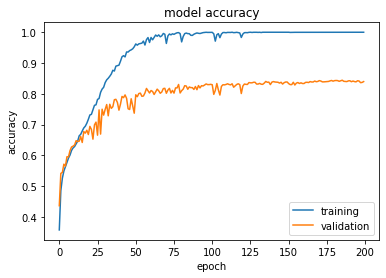

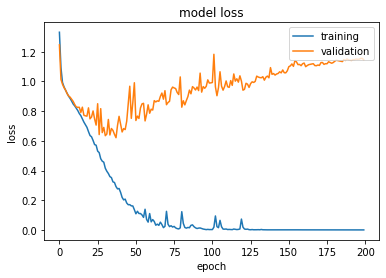

In [ ]:
from matplotlib import pyplot as plt
# 学習状況のプロット関数の定義
# 分類精度の履歴をプロット
plt.plot([a.cpu() for a in acc_hist[0]])
plt.plot([a.cpu() for a in acc_hist[1]])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

# 損失関数の履歴をプロット
plt.plot(loss_hist[0])
plt.plot(loss_hist[1])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()


# Save the model

In [ ]:
model_path = RESEARCH_WORK_PATH + 'models/multimodal.pth'
torch.save(model.state_dict(), model_path)

# 疑問点
入力画素数はどこでわかる？